# Partisan domain bias score analysis

This file is to analyze the partisan bias score distribution for searches of the Democratic and Republican members. 

Import the libraries

In [71]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

Import domain list and their proportions, import bias score from Ronald et al. 2018.

In [72]:
dem_rep_prop = pd.read_csv('../data/house_analysis/domain_dem_rep_prop.csv')

In [73]:
ron_news = pd.read_csv('../data/bias_score_ron_2018.csv')

Attach bias score to the domian list.

In [74]:
domain_ratings = ron_news[ron_news['domain'].isin(dem_rep_prop.domain)]

In [75]:
all_domain_leaning_prop = pd.merge(dem_rep_prop, domain_ratings[['domain', 'bias_score']].drop_duplicates(), how="left", on='domain')

In [76]:
all_domain_leaning_prop

,domain,dem_prop,rep_prop,bias_score
0,1011now.com,3.210876e-05,0.000607,0.5387
1,10news.com,6.413415e-05,0.000000,0.3315
2,10tv.com,1.340624e-04,0.000153,0.1897
3,11alive.com,3.173479e-04,0.000356,0.1956
4,12news.com,9.466487e-05,0.000073,0.1167
...,...,...,...,...
4214,yubanet.com,1.389276e-05,0.000000,NaN
4215,zanesvilletimesrecorder.com,0.000000e+00,0.000037,NaN
4216,zeldinforcongress.com,0.000000e+00,0.000365,NaN
4217,zerotothree.org,1.846016e-07,0.000000,NaN


In [77]:
all_domain_leaning_prop.to_csv("../data/house_analysis/domain_party_proportion_with_biasscore.csv", index=False)

Calculate the rate of domains with bias score.

In [78]:
# Coverage rate
len(all_domain_leaning_prop.dropna())/len(all_domain_leaning_prop)

0.4159753496089121

In [79]:
all_domain_leaning_prop_no_nan = all_domain_leaning_prop.dropna()

Plot distribution of bias scores for both party. 

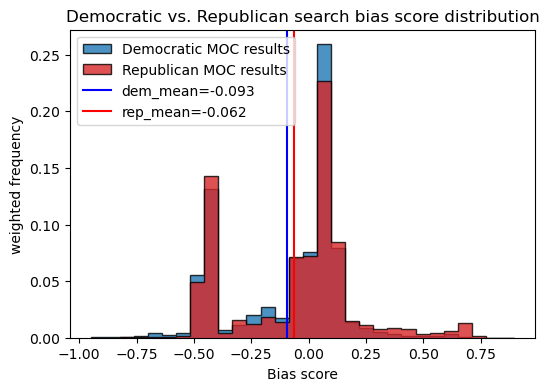

In [80]:
fig, ax = plt.subplots(figsize = (6, 4))
plt.hist(all_domain_leaning_prop_no_nan['bias_score'], edgecolor='black', bins=30, weights=all_domain_leaning_prop_no_nan['dem_prop'], 
         histtype='step', fill=True, color='#1f77b4', label='Democratic MOC results', alpha = 0.8)
plt.hist(all_domain_leaning_prop_no_nan['bias_score'], edgecolor='black', bins=30, weights=all_domain_leaning_prop_no_nan['rep_prop'], 
         histtype='step', fill=True, color='#d62728', label='Republican MOC results', alpha = 0.8)

dem_weighted_avg = np.average(all_domain_leaning_prop_no_nan['bias_score'], weights=all_domain_leaning_prop_no_nan['dem_prop'])
plt.axvline(x = dem_weighted_avg, color = 'b',label = 'dem_mean='+str(round(dem_weighted_avg, 3)))
rep_weighted_avg = np.average(all_domain_leaning_prop_no_nan['bias_score'], weights=all_domain_leaning_prop_no_nan['rep_prop'])
plt.axvline(x = rep_weighted_avg, color = 'r',label = 'rep_mean='+str(round(rep_weighted_avg, 3)))
plt.legend()
 
plt.xlabel('Bias score')
plt.ylabel('weighted frequency')
plt.title("Democratic vs. Republican search bias score distribution")
plt.savefig("../data/plots/dem_rep_bias_score_dist.png", bbox_inches='tight', dpi=200) 
plt.show()

In [81]:
dem_weighted_avg, rep_weighted_avg

(-0.09321695186894131, -0.06226655326891947)

In [82]:
dem_weighted_avg-rep_weighted_avg

-0.03095039860002184

## Stats test on the difference between distribution for all type domains

Define function to calculate weighted ks score. This is to tell us whether the difference between the democratic and republican search result domains is significant. 

In [83]:
# define weighted ks test
# code from https://stackoverflow.com/questions/40044375/how-to-calculate-the-kolmogorov-smirnov-statistic-between-two-weighted-samples
from scipy.stats import distributions

def ks_weighted(data1, data2, wei1, wei2, alternative='two-sided'):
    ix1 = np.argsort(data1)
    ix2 = np.argsort(data2)
    data1 = data1[ix1]
    data2 = data2[ix2]
    wei1 = wei1[ix1]
    wei2 = wei2[ix2]
    data = np.concatenate([data1, data2])
    cwei1 = np.hstack([0, np.cumsum(wei1)/sum(wei1)])
    cwei2 = np.hstack([0, np.cumsum(wei2)/sum(wei2)])
    cdf1we = cwei1[np.searchsorted(data1, data, side='right')]
    cdf2we = cwei2[np.searchsorted(data2, data, side='right')]
    d = np.max(np.abs(cdf1we - cdf2we))
    # calculate p-value
    n1 = data1.shape[0]
    n2 = data2.shape[0]
    m, n = sorted([float(n1), float(n2)], reverse=True)
    en = m * n / (m + n)
    if alternative == 'two-sided':
        prob = distributions.kstwo.sf(d, np.round(en))
    else:
        z = np.sqrt(en) * d
        # Use Hodges' suggested approximation Eqn 5.3
        # Requires m to be the larger of (n1, n2)
        expt = -2 * z**2 - 2 * z * (m + 2*n)/np.sqrt(m*n*(m+n))/3.0
        prob = np.exp(expt)
    return d, prob

Calculate weighted bias.

In [84]:
bias_scores = np.array(all_domain_leaning_prop_no_nan['bias_score'])
dem_prop = np.array(all_domain_leaning_prop_no_nan['dem_prop'])
rep_prop = np.array(all_domain_leaning_prop_no_nan['rep_prop'])

d, p = ks_weighted(bias_scores, bias_scores, dem_prop, rep_prop, alternative='two-sided')

In [85]:
d, p

(0.059390169205248644, 0.0039126981735898856)

# News only

Import domain categories.

In [86]:
allison_cat = pd.read_csv("../data/domain_category.csv")

In [87]:
cleaned_cat = allison_cat[['domain','category']].drop_duplicates()

In [88]:
all_domain_leaning_prop_cat = pd.merge(all_domain_leaning_prop, cleaned_cat, how="left", on='domain')

In [89]:
all_domain_leaning_prop_cat

,domain,dem_prop,rep_prop,bias_score,category
0,1011now.com,3.210876e-05,0.000607,0.5387,news
1,10news.com,6.413415e-05,0.000000,0.3315,news
2,10tv.com,1.340624e-04,0.000153,0.1897,news
3,11alive.com,3.173479e-04,0.000356,0.1956,news
4,12news.com,9.466487e-05,0.000073,0.1167,news
...,...,...,...,...,...
4214,yubanet.com,1.389276e-05,0.000000,NaN,news
4215,zanesvilletimesrecorder.com,0.000000e+00,0.000037,NaN,news
4216,zeldinforcongress.com,0.000000e+00,0.000365,NaN,campaign_personal
4217,zerotothree.org,1.846016e-07,0.000000,NaN,other_third_party


In [90]:
news_leaning = all_domain_leaning_prop_cat[all_domain_leaning_prop_cat["category"]=="news"]

In [91]:
news_leaning_no_nan = news_leaning.dropna()

In [92]:
len(news_leaning_no_nan)/len(news_leaning)

0.4756317689530686

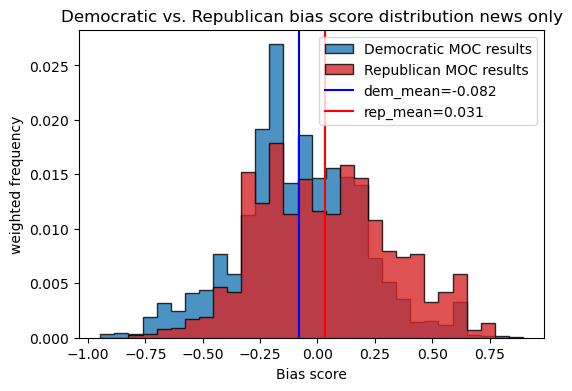

In [93]:
fig, ax = plt.subplots(figsize = (6, 4))
plt.hist(news_leaning_no_nan['bias_score'], edgecolor='black', bins=30, weights=news_leaning_no_nan['dem_prop'], 
         histtype='step', fill=True, color='#1f77b4', label='Democratic MOC results', alpha = 0.8)
plt.hist(news_leaning_no_nan['bias_score'], edgecolor='black', bins=30, weights=news_leaning_no_nan['rep_prop'], 
         histtype='step', fill=True, color='#d62728', label='Republican MOC results', alpha = 0.8)

dem_weighted_avg = np.average(news_leaning_no_nan['bias_score'], weights=news_leaning_no_nan['dem_prop'])
plt.axvline(x = dem_weighted_avg, color = 'b',label = 'dem_mean='+str(round(dem_weighted_avg, 3)))
rep_weighted_avg = np.average(news_leaning_no_nan['bias_score'], weights=news_leaning_no_nan['rep_prop'])
plt.axvline(x = rep_weighted_avg, color = 'r',label = 'rep_mean='+str(round(rep_weighted_avg, 3)))
plt.legend()
 
plt.xlabel('Bias score')
plt.ylabel('weighted frequency')
plt.title("Democratic vs. Republican bias score distribution news only")
plt.savefig("../data/plots/dem_rep_news_bias_score_dist.png", bbox_inches='tight', dpi=200) 
plt.show()

In [94]:
dem_weighted_avg, rep_weighted_avg

(-0.08200442607366294, 0.030840563211191344)

In [95]:
dem_weighted_avg-rep_weighted_avg

-0.11284498928485429

In [96]:
bias_scores2 = np.array(news_leaning_no_nan['bias_score'])
dem_prop2 = np.array(news_leaning_no_nan['dem_prop'])
rep_prop2 = np.array(news_leaning_no_nan['rep_prop'])

d2, p2 = ks_weighted(bias_scores2, bias_scores2, dem_prop2, rep_prop2, alternative='two-sided')

In [97]:
d2, p2

(0.17472157023622903, 1.4584122228356128e-21)

In [98]:
7.815679177479203e-20

7.815679177479203e-20